# Introduction

**Contents:** Solves and simulates a simple consumption-saving model

**Solution methods:** Value function iteration (`vfi`) and the endogenous grid-point method (`egm`)

**Simulation methods:** Monte Carlo (`mc`) and the historgram method (`hist`)

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Consumption-Saving Model

**Additional packages to consider:**

1. [quantecon](https://quantecon.org/)
2. [consav](https://github.com/NumEconCopenhagen/ConsumptionSaving) ([notebooks](https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks))

**Local model file:**

In [2]:
from ConSavModel import ConSavModelClass

## Setup

In [3]:
model_vfi = ConSavModelClass()

In [4]:
par = model_vfi.par
sol = model_vfi.sol
sim = model_vfi.sim

**Grids:**

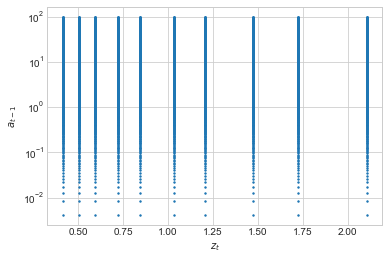

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$');

**Transition matrix for $z_t$:**

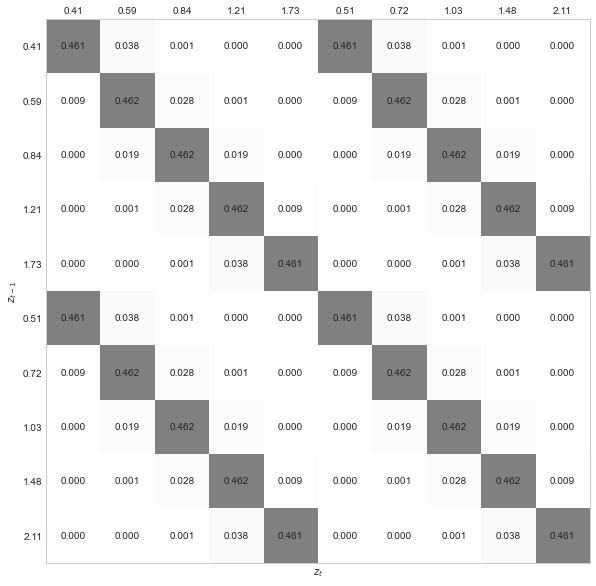

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.grid(False)
h = ax.matshow(par.z_trans,cmap='Greys',alpha=0.5)

for (i, j), value in np.ndenumerate(par.z_trans):
    ax.text(j, i, f'{value:0.3f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t}$')
ax.set_ylabel('$z_{t-1}$');

**Ergodic distribution:**

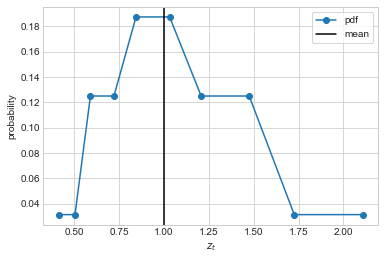

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],par.z_ergodic[I],'-o',label='pdf')
ax.axvline(np.sum(par.z_ergodic*par.z_grid),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True);

**Cummulative distributions:**

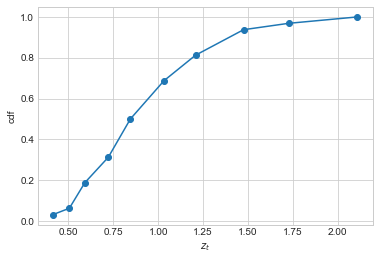

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],np.cumsum(par.z_ergodic[I]),'-o')
ax.set_xlabel('$z_t$')
ax.set_ylabel('cdf');

## Solve - value function interation (vfi)

In [9]:
model_vfi.solve(do_print=True,algo='vfi')

iteration    0 solved in 28.5 secs  [max abs. diff. 2.02e+00]
iteration    1 solved in 0.2 secs   [max abs. diff. 1.89e+00]
iteration    2 solved in 0.1 secs   [max abs. diff. 1.78e+00]
iteration    3 solved in 0.1 secs   [max abs. diff. 1.67e+00]
iteration    4 solved in 0.1 secs   [max abs. diff. 1.57e+00]
iteration    5 solved in 0.1 secs   [max abs. diff. 1.48e+00]
iteration    6 solved in 0.1 secs   [max abs. diff. 1.39e+00]
iteration    7 solved in 0.1 secs   [max abs. diff. 1.31e+00]
iteration    8 solved in 0.1 secs   [max abs. diff. 1.24e+00]
iteration    9 solved in 0.1 secs   [max abs. diff. 1.17e+00]
iteration  100 solved in 0.1 secs   [max abs. diff. 1.85e-02]
iteration  200 solved in 0.1 secs   [max abs. diff. 3.09e-04]
iteration  300 solved in 0.1 secs   [max abs. diff. 5.21e-06]
iteration  400 solved in 0.1 secs   [max abs. diff. 8.78e-08]
iteration  454 solved in 0.1 secs   [max abs. diff. 9.69e-09]
model solved in 1.0 mins 18 secs


**Question:** What role does the argument `c_plus` play in `solve_hh_backwards_vfi`?

## Plot consumption function and change in savings function

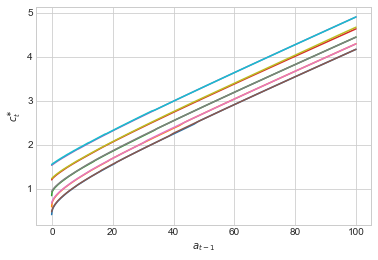

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.c[i_z,:])
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t^{\\ast}$');

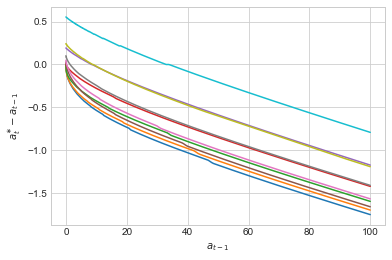

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid)
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

**Note:** Good this ends up negative, then we do not extrapolate beyond the grid.

## Simulate - monte carlo 

In [12]:
model_mc = model_vfi.copy()

In [13]:
model_mc.prepare_simulate(algo='mc')
model_mc.simulate(algo='mc')

model prepared for simulation in 0.5 secs
model simulated in 3.3 secs secs


## Simulate - historgram

In [14]:
model_hist = model_vfi.copy()

In [15]:
model_hist.prepare_simulate(algo='hist')
model_hist.simulate(algo='hist')

model prepared for simulation in 0.0 secs
model simulated in 3.2 secs secs


## Compare simulation methods

**Aggregate savings in last 100 periods on average:**

In [16]:
Nperiods = 100
A_mc = np.mean(model_mc.sim.a[-Nperiods:])
A_hist = np.sum(model_hist.sol.a*model_hist.sim.D[-Nperiods:])/Nperiods

print(f'{A_mc   = :7.4f}')
print(f'{A_hist = :7.4f}')

A_mc   =  1.2806
A_hist =  1.2720


**CDF:**

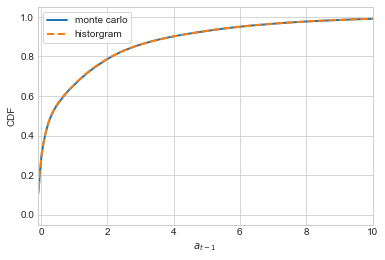

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

CDF_mc = np.zeros(par.Na)
for i_a in range(par.Na):
    CDF_mc[i_a] = np.sum(model_mc.sim.a[-1,:] < par.a_grid[i_a])/par.simN

CDF_hist = np.cumsum(np.sum(model_hist.sim.D[-1],axis=(0,)))

ax.plot(par.a_grid,CDF_mc,lw=2,label='monte carlo')
ax.plot(par.a_grid,CDF_hist,ls='--',lw=2,label='historgram')

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('CDF')
ax.set_xlim([par.b,10.0])
ax.legend(frameon=True);

**Question 1:** How many liquidity constraints are there in the model?

**Question 2:** Look at the figure below. Does `simT` and `simN` matter for the distribution?

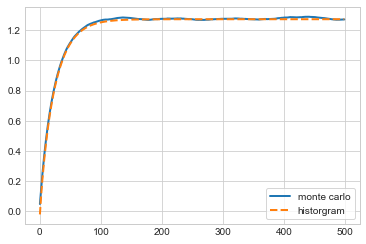

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

A_mc = np.mean(model_mc.sim.a,axis=1)
A_hist = np.sum(model_hist.sim.D*model_hist.sol.a,axis=(1,2))

ax.plot(A_mc,lw=2,label='monte carlo')
ax.plot(A_hist,ls='--',lw=2,label='historgram')

ax.legend(frameon=True);

**Question 3:** Why is the method below useful?

In [19]:
model_hist.simulate_hist_alt(do_print=True)

model simulated in 0.6 secs [271 iterations]


## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question on https://padlet.com/jeppe_druedahl/advmacrohet

## Solve - endogenous grid method (egm)

In [20]:
model_egm = model_vfi.copy()

In [21]:
model_egm.solve(do_print=True,algo='egm')

iteration    0 solved in 2.1 secs   [max abs. diff. 4.96e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.35e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.02e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.35e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.39e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.80e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.40e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.12e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.15e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 3.28e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 3.03e-06]
iteration  269 solved in 0.0 secs   [max abs. diff. 9.93e-09]
model solved in 2.3 secs


**Question:** Why is `egm` so much faster than `vfi`?

## Compare solution methods

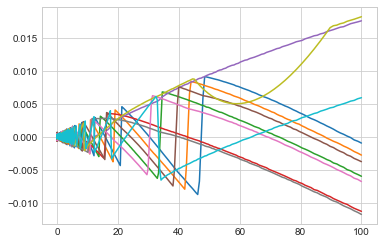

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,model_egm.sol.a[i_z,:]-model_vfi.sol.a[i_z,:])